In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import numpy as np
import pickle
sys.path.append('D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin')
from models import *
from clients_datasets import *
from tqdm.notebook import tqdm
from utils import *
from AttFunc import *
from Fisher_LeNet import *

In [25]:
batch_size = 600
epochs = 30
NC = 10
dataset = 'cifar10'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 6

criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [26]:
losses = []  # 用于存放每个全局轮次的loss
test_accuracies = []  # 用于存放每个全局轮次的测试准确率
#################################################################################
###########################   Normal training   #################################
# train
server.apply(init_weights)
clients[0].apply(init_weights)
last_trained_params = clients[0].state_dict()
for epoch in tqdm(range(epochs), desc="Normal Training", unit="epoch"):
    epoch_loss = 0.0
    server.train()
    for i in range(NC):
        clients[i].train()
    for idx, client in enumerate(clients):
        client.load_state_dict(last_trained_params)
        for j, data in enumerate(clients_trainloader[idx]):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            smashed_data = client.forward(images, client_level=client_level)
            output = server.forward(smashed_data, server_level=server_level)
            clients_opts[idx].zero_grad()
            server_opt.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            clients_opts[idx].step()
            server_opt.step()
            epoch_loss += loss.item()  # 累加每个batch的loss
        last_trained_params = client.state_dict()
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)
    # 计算并保存每个全局轮次的平均loss
    average_loss = epoch_loss / len(clients)
    losses.append(average_loss)

    # 测试并保存每个全局轮次的准确率
    server.eval()
    clients_acc0 = []
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc0 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc0 = 100 * correct / total
            clients_acc0.append(acc0)
    test_accuracies.append(np.mean(clients_acc0))

    # 将全局轮次的loss和测试结果输出
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {np.mean(clients_acc0):.2f}%')

# 最终保存loss和准确率数组
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss1.npy', losses)
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc1.npy', test_accuracies)


Normal Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch [1/30], Loss: 14.8250, Accuracy: 61.03%
Epoch [2/30], Loss: 8.1730, Accuracy: 70.77%
Epoch [3/30], Loss: 6.1600, Accuracy: 73.73%
Epoch [4/30], Loss: 4.6700, Accuracy: 71.19%
Epoch [5/30], Loss: 3.6260, Accuracy: 76.06%
Epoch [6/30], Loss: 2.6589, Accuracy: 76.45%
Epoch [7/30], Loss: 1.7814, Accuracy: 75.24%
Epoch [8/30], Loss: 1.0906, Accuracy: 78.10%
Epoch [9/30], Loss: 0.6529, Accuracy: 79.02%
Epoch [10/30], Loss: 0.4205, Accuracy: 80.32%
Epoch [11/30], Loss: 0.3010, Accuracy: 80.96%
Epoch [12/30], Loss: 0.1596, Accuracy: 82.40%
Epoch [13/30], Loss: 0.1234, Accuracy: 79.65%
Epoch [14/30], Loss: 0.0754, Accuracy: 82.47%
Epoch [15/30], Loss: 0.0436, Accuracy: 84.31%
Epoch [16/30], Loss: 0.0218, Accuracy: 84.83%
Epoch [17/30], Loss: 0.0081, Accuracy: 85.59%
Epoch [18/30], Loss: 0.0036, Accuracy: 86.03%
Epoch [19/30], Loss: 0.0026, Accuracy: 86.05%
Epoch [20/30], Loss: 0.0021, Accuracy: 85.99%
Epoch [21/30], Loss: 0.0018, Accuracy: 85.93%
Epoch [22/30], Loss: 0.0016, Accuracy: 85.

In [37]:
batch_size = 600
epochs = 30
NC = 10
dataset = 'cifar10'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 6

criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [38]:
clients_acc0 = []
losses = []
test_accuracies = []
#################################################################################
###########################   Normal training   #################################
# train
server.train()
for i in range(NC):
    clients[i].train()
for epoch in tqdm(range(epochs), desc="Normal Training", unit="epoch"):
    epoch_loss = 0.0
    for idx, client in enumerate(clients):
        for j, data in enumerate(clients_trainloader[idx]):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            smashed_data = client.forward(images, client_level=client_level)
            output = server.forward(smashed_data, server_level=server_level)
            clients_opts[idx].zero_grad()
            server_opt.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            clients_opts[idx].step()
            server_opt.step()
            epoch_loss += loss.item()  # 累加每个batch的loss
    # 计算并保存每个全局轮次的平均loss
    average_loss = epoch_loss / len(clients)
    losses.append(average_loss)
    # 测试并保存每个全局轮次的准确率
    server.eval()
    clients_acc0 = []
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc0 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc0 = 100 * correct / total
            clients_acc0.append(acc0)
    test_accuracies.append(np.mean(clients_acc0))
    # 将全局轮次的loss和测试结果输出
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {np.mean(clients_acc0):.2f}%')

# 最终保存loss和准确率数组
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss2.npy', losses)
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc2.npy', test_accuracies)

Normal Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch [1/30], Loss: 18.1341, Accuracy: 23.31%
Epoch [2/30], Loss: 18.1695, Accuracy: 26.88%
Epoch [3/30], Loss: 15.9675, Accuracy: 38.90%
Epoch [4/30], Loss: 14.3254, Accuracy: 43.55%
Epoch [5/30], Loss: 13.3808, Accuracy: 47.89%
Epoch [6/30], Loss: 12.4065, Accuracy: 47.81%
Epoch [7/30], Loss: 12.0379, Accuracy: 51.59%
Epoch [8/30], Loss: 11.1296, Accuracy: 54.47%
Epoch [9/30], Loss: 10.2411, Accuracy: 56.21%
Epoch [10/30], Loss: 9.6166, Accuracy: 59.66%
Epoch [11/30], Loss: 8.9861, Accuracy: 58.60%
Epoch [12/30], Loss: 8.6536, Accuracy: 59.67%
Epoch [13/30], Loss: 7.7174, Accuracy: 63.93%
Epoch [14/30], Loss: 7.1239, Accuracy: 60.82%
Epoch [15/30], Loss: 6.6545, Accuracy: 65.32%
Epoch [16/30], Loss: 6.0268, Accuracy: 66.09%
Epoch [17/30], Loss: 5.4344, Accuracy: 66.13%
Epoch [18/30], Loss: 5.2724, Accuracy: 66.40%
Epoch [19/30], Loss: 4.2815, Accuracy: 65.08%
Epoch [20/30], Loss: 3.8078, Accuracy: 65.16%
Epoch [21/30], Loss: 3.4357, Accuracy: 67.28%
Epoch [22/30], Loss: 3.2322, Accur

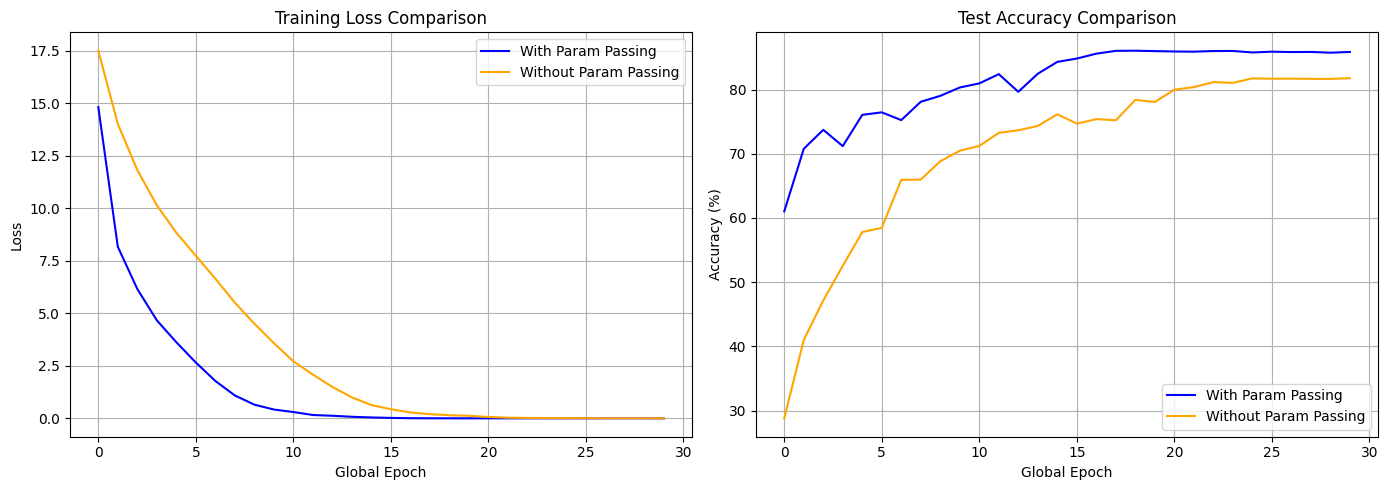

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 读取保存的loss和测试准确率数据
losses_with_params = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss1.npy')
test_accuracies_with_params = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc1.npy')
losses_no_params = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss2.npy')
test_accuracies_no_params = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc2.npy')

# 创建一个figure和两个子图
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# 绘制loss对比曲线
axs[0].plot(losses_with_params, label='With Param Passing', color='blue')
axs[0].plot(losses_no_params, label='Without Param Passing', color='orange')
axs[0].set_xlabel('Global Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss Comparison')
axs[0].legend()
axs[0].grid(True)

# 绘制测试准确率对比曲线
axs[1].plot(test_accuracies_with_params, label='With Param Passing', color='blue')
axs[1].plot(test_accuracies_no_params, label='Without Param Passing', color='orange')
axs[1].set_xlabel('Global Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Test Accuracy Comparison')
axs[1].legend()
axs[1].grid(True)

# 显示图表
plt.tight_layout()
plt.show()


In [31]:
batch_size = 600
epochs = 30
NC = 10
dataset = 'svhn'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 6

criterion = torch.nn.CrossEntropyLoss()

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [32]:
losses = []  # 用于存放每个全局轮次的loss
test_accuracies = []  # 用于存放每个全局轮次的测试准确率
#################################################################################
###########################   Normal training   #################################
# train
server.apply(init_weights)
clients[0].apply(init_weights)
last_trained_params = clients[0].state_dict()
for epoch in tqdm(range(epochs), desc="Normal Training", unit="epoch"):
    epoch_loss = 0.0
    server.train()
    for i in range(NC):
        clients[i].train()
    for idx, client in enumerate(clients):
        client.load_state_dict(last_trained_params)
        for j, data in enumerate(clients_trainloader[idx]):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            smashed_data = client.forward(images, client_level=client_level)
            output = server.forward(smashed_data, server_level=server_level)
            clients_opts[idx].zero_grad()
            server_opt.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            clients_opts[idx].step()
            server_opt.step()
            epoch_loss += loss.item()  # 累加每个batch的loss
        last_trained_params = client.state_dict()
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)
    # 计算并保存每个全局轮次的平均loss
    average_loss = epoch_loss / len(clients)
    losses.append(average_loss)

    # 测试并保存每个全局轮次的准确率
    server.eval()
    clients_acc0 = []
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc0 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc0 = 100 * correct / total
            clients_acc0.append(acc0)
    test_accuracies.append(np.mean(clients_acc0))

    # 将全局轮次的loss和测试结果输出
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {np.mean(clients_acc0):.2f}%')

# 最终保存loss和准确率数组
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss1.npy', losses)
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc1.npy', test_accuracies)


Normal Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch [1/30], Loss: 29.0269, Accuracy: 50.28%
Epoch [2/30], Loss: 7.3637, Accuracy: 89.95%
Epoch [3/30], Loss: 3.3801, Accuracy: 92.79%
Epoch [4/30], Loss: 2.6001, Accuracy: 93.30%
Epoch [5/30], Loss: 2.0923, Accuracy: 93.75%
Epoch [6/30], Loss: 1.7090, Accuracy: 93.60%
Epoch [7/30], Loss: 1.3785, Accuracy: 93.66%
Epoch [8/30], Loss: 1.0574, Accuracy: 94.00%
Epoch [9/30], Loss: 0.7376, Accuracy: 93.16%
Epoch [10/30], Loss: 0.4985, Accuracy: 94.29%
Epoch [11/30], Loss: 0.3307, Accuracy: 94.02%
Epoch [12/30], Loss: 0.2736, Accuracy: 92.53%
Epoch [13/30], Loss: 0.2072, Accuracy: 93.43%
Epoch [14/30], Loss: 0.1619, Accuracy: 94.39%
Epoch [15/30], Loss: 0.1673, Accuracy: 94.35%
Epoch [16/30], Loss: 0.1398, Accuracy: 93.63%
Epoch [17/30], Loss: 0.2159, Accuracy: 94.00%
Epoch [18/30], Loss: 0.3602, Accuracy: 94.05%
Epoch [19/30], Loss: 0.2609, Accuracy: 94.05%
Epoch [20/30], Loss: 0.2873, Accuracy: 93.47%
Epoch [21/30], Loss: 0.1394, Accuracy: 94.85%
Epoch [22/30], Loss: 0.0597, Accuracy: 95.

In [39]:
batch_size = 600
epochs = 30
NC = 10
dataset = 'svhn'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 6

criterion = torch.nn.CrossEntropyLoss()

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [40]:
losses = []
test_accuracies = []
#################################################################################
###########################   Normal training   #################################
# train
server.train()
for i in range(NC):
    clients[i].train()
for epoch in tqdm(range(epochs), desc="Normal Training", unit="epoch"):
    epoch_loss = 0.0
    for idx, client in enumerate(clients):
        for j, data in enumerate(clients_trainloader[idx]):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            smashed_data = client.forward(images, client_level=client_level)
            output = server.forward(smashed_data, server_level=server_level)
            clients_opts[idx].zero_grad()
            server_opt.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            clients_opts[idx].step()
            server_opt.step()
            epoch_loss += loss.item()  # 累加每个batch的loss
    # 计算并保存每个全局轮次的平均loss
    average_loss = epoch_loss / len(clients)
    losses.append(average_loss)
    # 测试并保存每个全局轮次的准确率
    server.eval()
    clients_acc0 = []
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc0 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc0 = 100 * correct / total
            clients_acc0.append(acc0)
    test_accuracies.append(np.mean(clients_acc0))
    # 将全局轮次的loss和测试结果输出
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {np.mean(clients_acc0):.2f}%')

# 最终保存loss和准确率数组
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss2.npy', losses)
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc2.npy', test_accuracies)

Normal Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch [1/30], Loss: 24.5389, Accuracy: 45.03%
Epoch [2/30], Loss: 11.0374, Accuracy: 83.37%
Epoch [3/30], Loss: 5.6585, Accuracy: 86.95%
Epoch [4/30], Loss: 4.2970, Accuracy: 90.23%
Epoch [5/30], Loss: 3.4248, Accuracy: 90.63%
Epoch [6/30], Loss: 2.9898, Accuracy: 91.28%
Epoch [7/30], Loss: 2.5643, Accuracy: 90.22%
Epoch [8/30], Loss: 2.1562, Accuracy: 92.47%
Epoch [9/30], Loss: 1.6534, Accuracy: 91.01%
Epoch [10/30], Loss: 1.3929, Accuracy: 90.67%
Epoch [11/30], Loss: 1.3196, Accuracy: 91.36%
Epoch [12/30], Loss: 1.0594, Accuracy: 91.64%
Epoch [13/30], Loss: 1.0709, Accuracy: 90.47%
Epoch [14/30], Loss: 0.8203, Accuracy: 91.69%
Epoch [15/30], Loss: 0.8195, Accuracy: 91.47%
Epoch [16/30], Loss: 0.5114, Accuracy: 91.59%
Epoch [17/30], Loss: 0.5232, Accuracy: 91.69%
Epoch [18/30], Loss: 0.3849, Accuracy: 91.45%
Epoch [19/30], Loss: 0.3526, Accuracy: 92.40%
Epoch [20/30], Loss: 0.6706, Accuracy: 91.42%
Epoch [21/30], Loss: 0.4165, Accuracy: 92.29%
Epoch [22/30], Loss: 0.3561, Accuracy: 91

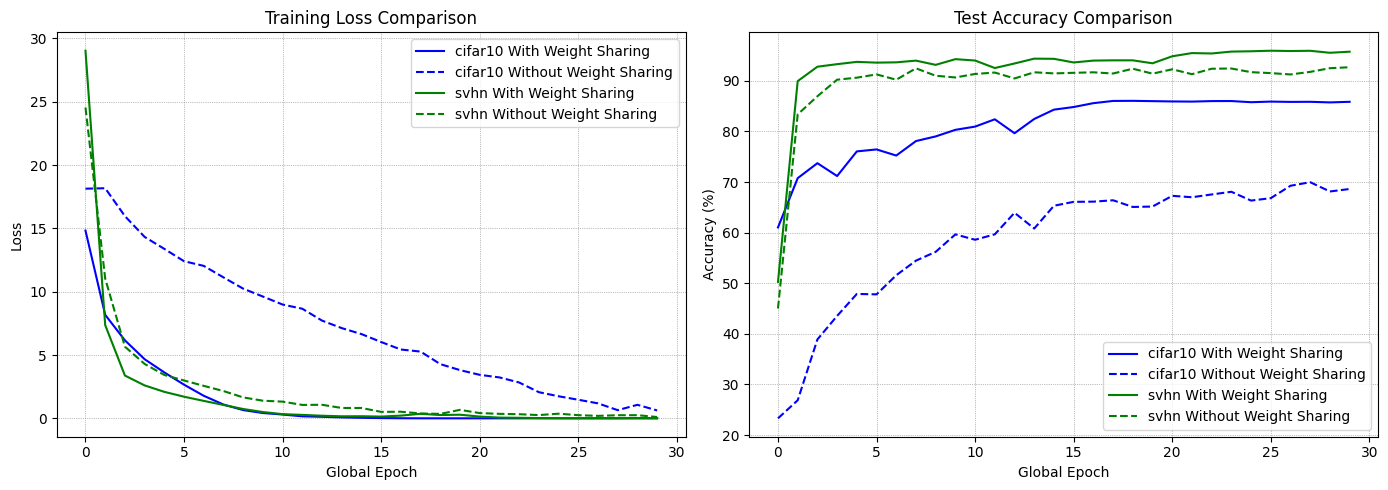

In [42]:
dataset1 = 'cifar10'
dataset2 = 'svhn'

# 读取第一个数据集的loss和准确率数据
losses_with_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-loss1.npy')
test_accuracies_with_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-acc1.npy')
losses_no_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-loss2.npy')
test_accuracies_no_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-acc2.npy')

# 读取第二个数据集的loss和准确率数据
losses_with_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-loss1.npy')
test_accuracies_with_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-acc1.npy')
losses_no_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-loss2.npy')
test_accuracies_no_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-acc2.npy')

# 创建一个figure和两个子图
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# 绘制loss对比曲线
axs[0].plot(losses_with_sharing_1, label=f'{dataset1} With Weight Sharing', color='blue', linestyle='-')
axs[0].plot(losses_no_sharing_1, label=f'{dataset1} Without Weight Sharing', color='blue', linestyle='--')
axs[0].plot(losses_with_sharing_2, label=f'{dataset2} With Weight Sharing', color='green', linestyle='-')
axs[0].plot(losses_no_sharing_2, label=f'{dataset2} Without Weight Sharing', color='green', linestyle='--')
axs[0].set_xlabel('Global Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss Comparison')
axs[0].legend()
axs[0].grid(True, linestyle=':', linewidth=0.5, color='gray')

# 绘制测试准确率对比曲线
axs[1].plot(test_accuracies_with_sharing_1, label=f'{dataset1} With Weight Sharing', color='blue', linestyle='-')
axs[1].plot(test_accuracies_no_sharing_1, label=f'{dataset1} Without Weight Sharing', color='blue', linestyle='--')
axs[1].plot(test_accuracies_with_sharing_2, label=f'{dataset2} With Weight Sharing', color='green', linestyle='-')
axs[1].plot(test_accuracies_no_sharing_2, label=f'{dataset2} Without Weight Sharing', color='green', linestyle='--')
axs[1].set_xlabel('Global Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Test Accuracy Comparison')
axs[1].legend()
axs[1].grid(True, linestyle=':', linewidth=0.5, color='gray')

# 显示图表
plt.tight_layout()
plt.show()

In [44]:
batch_size = 600
epochs = 30
NC = 10
dataset = 'f_mnist'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 4

criterion = torch.nn.CrossEntropyLoss()

In [45]:
losses = []  # 用于存放每个全局轮次的loss
test_accuracies = []  # 用于存放每个全局轮次的测试准确率
#################################################################################
###########################   Normal training   #################################
# train
server.apply(init_weights)
clients[0].apply(init_weights)
last_trained_params = clients[0].state_dict()
for epoch in tqdm(range(epochs), desc="Normal Training", unit="epoch"):
    epoch_loss = 0.0
    server.train()
    for i in range(NC):
        clients[i].train()
    for idx, client in enumerate(clients):
        client.load_state_dict(last_trained_params)
        for j, data in enumerate(clients_trainloader[idx]):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            smashed_data = client.forward(images, client_level=client_level)
            output = server.forward(smashed_data, server_level=server_level)
            clients_opts[idx].zero_grad()
            server_opt.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            clients_opts[idx].step()
            server_opt.step()
            epoch_loss += loss.item()  # 累加每个batch的loss
        last_trained_params = client.state_dict()
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)
    # 计算并保存每个全局轮次的平均loss
    average_loss = epoch_loss / len(clients)
    losses.append(average_loss)

    # 测试并保存每个全局轮次的准确率
    server.eval()
    clients_acc0 = []
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc0 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc0 = 100 * correct / total
            clients_acc0.append(acc0)
    test_accuracies.append(np.mean(clients_acc0))

    # 将全局轮次的loss和测试结果输出
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {np.mean(clients_acc0):.2f}%')

# 最终保存loss和准确率数组
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss1.npy', losses)
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc1.npy', test_accuracies)


Normal Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch [1/30], Loss: 10.5533, Accuracy: 75.41%
Epoch [2/30], Loss: 5.7980, Accuracy: 79.30%
Epoch [3/30], Loss: 5.0269, Accuracy: 81.38%
Epoch [4/30], Loss: 4.5983, Accuracy: 82.42%
Epoch [5/30], Loss: 4.2413, Accuracy: 84.98%
Epoch [6/30], Loss: 3.9976, Accuracy: 85.53%
Epoch [7/30], Loss: 3.7952, Accuracy: 85.93%
Epoch [8/30], Loss: 3.6270, Accuracy: 86.27%
Epoch [9/30], Loss: 3.4860, Accuracy: 86.07%
Epoch [10/30], Loss: 3.4058, Accuracy: 86.50%
Epoch [11/30], Loss: 3.3419, Accuracy: 86.53%
Epoch [12/30], Loss: 3.2243, Accuracy: 87.20%
Epoch [13/30], Loss: 3.1343, Accuracy: 87.55%
Epoch [14/30], Loss: 3.0334, Accuracy: 88.04%
Epoch [15/30], Loss: 3.0093, Accuracy: 87.69%
Epoch [16/30], Loss: 2.9339, Accuracy: 87.81%
Epoch [17/30], Loss: 2.8794, Accuracy: 88.02%
Epoch [18/30], Loss: 2.8513, Accuracy: 88.17%
Epoch [19/30], Loss: 2.7784, Accuracy: 88.33%
Epoch [20/30], Loss: 2.7662, Accuracy: 87.99%
Epoch [21/30], Loss: 2.7289, Accuracy: 88.73%
Epoch [22/30], Loss: 2.7019, Accuracy: 88.

In [46]:
batch_size = 600
epochs = 30
NC = 10
dataset = 'f_mnist'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 4

criterion = torch.nn.CrossEntropyLoss()

In [47]:
losses = []
test_accuracies = []
#################################################################################
###########################   Normal training   #################################
# train
server.train()
for i in range(NC):
    clients[i].train()
for epoch in tqdm(range(epochs), desc="Normal Training", unit="epoch"):
    epoch_loss = 0.0
    for idx, client in enumerate(clients):
        for j, data in enumerate(clients_trainloader[idx]):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            smashed_data = client.forward(images, client_level=client_level)
            output = server.forward(smashed_data, server_level=server_level)
            clients_opts[idx].zero_grad()
            server_opt.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            clients_opts[idx].step()
            server_opt.step()
            epoch_loss += loss.item()  # 累加每个batch的loss
    # 计算并保存每个全局轮次的平均loss
    average_loss = epoch_loss / len(clients)
    losses.append(average_loss)
    # 测试并保存每个全局轮次的准确率
    server.eval()
    clients_acc0 = []
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc0 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc0 = 100 * correct / total
            clients_acc0.append(acc0)
    test_accuracies.append(np.mean(clients_acc0))
    # 将全局轮次的loss和测试结果输出
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {np.mean(clients_acc0):.2f}%')

# 最终保存loss和准确率数组
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss2.npy', losses)
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc2.npy', test_accuracies)

Normal Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch [1/30], Loss: 20.5582, Accuracy: 42.33%
Epoch [2/30], Loss: 13.0206, Accuracy: 54.23%
Epoch [3/30], Loss: 10.8303, Accuracy: 57.66%
Epoch [4/30], Loss: 9.6678, Accuracy: 58.99%
Epoch [5/30], Loss: 9.1230, Accuracy: 60.34%
Epoch [6/30], Loss: 8.3315, Accuracy: 65.61%
Epoch [7/30], Loss: 7.6690, Accuracy: 66.60%
Epoch [8/30], Loss: 7.3851, Accuracy: 69.07%
Epoch [9/30], Loss: 7.4296, Accuracy: 72.18%
Epoch [10/30], Loss: 6.7160, Accuracy: 73.37%
Epoch [11/30], Loss: 6.3545, Accuracy: 74.72%
Epoch [12/30], Loss: 6.1252, Accuracy: 75.20%
Epoch [13/30], Loss: 6.0346, Accuracy: 74.85%
Epoch [14/30], Loss: 5.9876, Accuracy: 74.62%
Epoch [15/30], Loss: 5.8366, Accuracy: 76.35%
Epoch [16/30], Loss: 5.6301, Accuracy: 76.25%
Epoch [17/30], Loss: 5.4069, Accuracy: 77.78%
Epoch [18/30], Loss: 5.2020, Accuracy: 78.70%
Epoch [19/30], Loss: 5.0623, Accuracy: 79.11%
Epoch [20/30], Loss: 4.9607, Accuracy: 79.50%
Epoch [21/30], Loss: 4.9187, Accuracy: 80.02%
Epoch [22/30], Loss: 4.8611, Accuracy: 8

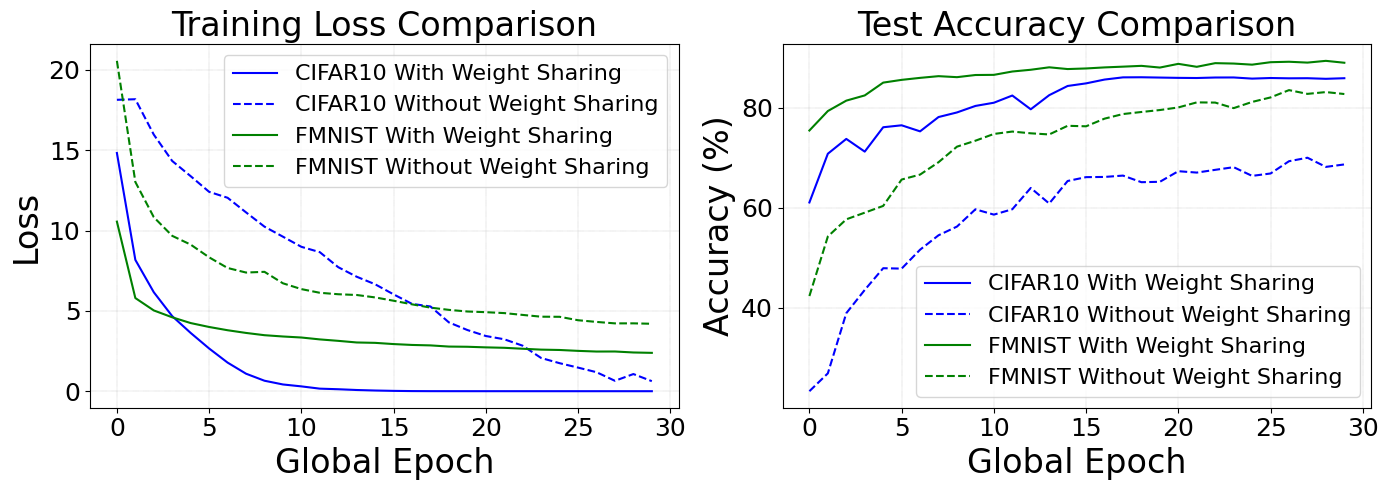

In [2]:
dataset1 = 'cifar10'
dataset2 = 'f_mnist'

# 读取第一个数据集的loss和准确率数据
losses_with_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-loss1.npy')
test_accuracies_with_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-acc1.npy')
losses_no_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-loss2.npy')
test_accuracies_no_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-acc2.npy')

# 读取第二个数据集的loss和准确率数据
losses_with_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-loss1.npy')
test_accuracies_with_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-acc1.npy')
losses_no_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-loss2.npy')
test_accuracies_no_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-acc2.npy')

# 创建一个figure和两个子图
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# 绘制loss对比曲线
axs[0].plot(losses_with_sharing_1, label=f'CIFAR10 With Weight Sharing', color='blue', linestyle='-')
axs[0].plot(losses_no_sharing_1, label=f'CIFAR10 Without Weight Sharing', color='blue', linestyle='--')
axs[0].plot(losses_with_sharing_2, label=f'FMNIST With Weight Sharing', color='green', linestyle='-')
axs[0].plot(losses_no_sharing_2, label=f'FMNIST Without Weight Sharing', color='green', linestyle='--')
axs[0].set_xlabel('Global Epoch', fontsize=24)
axs[0].set_ylabel('Loss', fontsize=24)
axs[0].set_title('Training Loss Comparison', fontsize=24)
axs[0].legend(fontsize=16)
axs[0].grid(True, linestyle=':', linewidth=0.3, color='gray')

# 绘制测试准确率对比曲线
axs[1].plot(test_accuracies_with_sharing_1, label=f'CIFAR10 With Weight Sharing', color='blue', linestyle='-')
axs[1].plot(test_accuracies_no_sharing_1, label=f'CIFAR10 Without Weight Sharing', color='blue', linestyle='--')
axs[1].plot(test_accuracies_with_sharing_2, label=f'FMNIST With Weight Sharing', color='green', linestyle='-')
axs[1].plot(test_accuracies_no_sharing_2, label=f'FMNIST Without Weight Sharing', color='green', linestyle='--')
axs[1].set_xlabel('Global Epoch', fontsize=24)
axs[1].set_ylabel('Accuracy (%)', fontsize=24)
axs[1].set_title('Test Accuracy Comparison', fontsize=24)
axs[1].legend(fontsize=16)
axs[1].grid(True, linestyle=':', linewidth=0.3, color='gray')

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=18)

# 显示图表
plt.tight_layout()
plt.show()